In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
import cvxpy as cp
import pandas as pd
from os.path import join
from scipy import ndimage
from scipy.spatial.distance import cdist
from scipy.sparse import csgraph
from scipy.stats import skew, kurtosis, norm
from itertools import product
from sklearn.model_selection import KFold
from matplotlib.animation import FuncAnimation
from nilearn import plotting, datasets, image
import os, sys

In [2]:
def clear_console():
    if os.name == "nt":
        os.system("cls")                     # Windows
    else:
        # Try tput (nicer), fall back to ANSI reset
        os.system("tput reset 2>/dev/null || printf '\033c'")


def find_active_voxels(glm_results, run, t_thr, R2_thr):
    if run == 1:
        betasmd = glm_results['betasmd'][:,:,:,0:90]
        R2 = glm_results['R2run'][:,:,:,0]
    else:
        betasmd = glm_results['betasmd'][:,:,:,90:]
        R2 = glm_results['R2run'][:,:,:,1]
    
    X, Y, Z, T = betasmd.shape
    V = X * Y * Z 
    B = betasmd.reshape(V, T)

    n = np.sum(~np.isnan(B), axis=1) # number of valid (non-NaN) trials for each voxel
    mu = np.nanmean(B, axis=1) 
    sd = np.nanstd(B, axis=1, ddof=1)
    se = sd / np.sqrt(np.clip(n, 1, None)); t = mu / se  #t-stat

    mu_vol = mu.reshape(X, Y, Z)
    sd_vol = sd.reshape(X, Y, Z)
    n_vol  = n.reshape(X, Y, Z)
    t_vol  = t.reshape(X, Y, Z)

    base = (R2 > R2_thr) & (np.abs(t_vol) > t_thr)
    mask_pos = base & (mu_vol > 0)
    mask_neg = base & (mu_vol < 0)

    clear_console()
    print(f"Number of Active Voxels {np.sum(base)} from Total Voxels: {V}")
    print(f"Number of Positively Active Voxels {np.sum(mask_pos)}, Number of Negatively Active Voxels {np.sum(mask_neg)}")
    
    return betasmd, mask_pos, mask_neg

def find_active_low_var_voxels(betasmd, mask_pos, mask_neg, sk_thr, kt_thr):
    mask_union = mask_pos | mask_neg
    beta_pos = betasmd[mask_union,:]
    beta_diff = np.diff(beta_pos, axis=1) #diff between consequence trial

    sk = skew(beta_diff, axis=1, bias=False)
    kt = kurtosis(beta_diff, axis=1, fisher=False, bias=False)
    mask_gaussian_like = (np.abs(sk) < sk_thr) & (np.abs(kt - 3) < kt_thr)

    selected_voxels = np.zeros(mask_pos.shape, dtype=bool)
    selected_voxels[mask_union] = mask_gaussian_like

    return selected_voxels, beta_diff

def plot_active_voxels(input, ses, run):
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    ax_sag, ax_cor, ax_axial = axes
    fig.suptitle(f"Less Variable Voxles-session {ses}-Run {run}")

    x = input.shape[0] // 2
    y = input.shape[1] // 2
    z = input.shape[2] // 2

    im_sag = ax_sag.imshow(np.rot90(input[x, :, :]), cmap="gray", origin='lower')
    ax_sag.set_title("Sagittal")
    ax_sag.axis("off")


    im_cor = ax_cor.imshow(np.rot90(input[:, y, :]), cmap="gray", origin='lower')
    ax_cor.set_title("Coronal")        
    ax_cor.axis("off")

    im_ax = ax_axial.imshow(np.rot90(input[:, :, z]), cmap="gray", origin='lower')
    ax_axial.set_title("Axial")   
    ax_axial.axis("off")


    def update(i):
        im_sag.set_data(np.rot90(input[i, :, :]))      # sagittal slices
        im_cor.set_data(np.rot90(input[:, i, :]))      # coronal slices
        im_ax.set_data(np.rot90(input[:, :, i]))       # axial slices
        return im_sag, im_cor, im_ax

    ani = FuncAnimation(fig, update, frames=range(min(input.shape)), interval=100, blit=False)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    ani.save(filename=f"selected_voxels_session{ses}_run{run}.gif", writer="pillow")
    plt.show()

    return

def plot_dist(beta_diff, run, ses):
    mu    = beta_diff.mean(axis=1)
    sigma = beta_diff.std(axis=1, ddof=1)  
    sk    = skew(beta_diff, axis=1, bias=False)
    kt    = kurtosis(beta_diff, axis=1, fisher=False, bias=False)
    rows_to_show = np.random.choice(beta_diff.shape[0], 5, replace=False)

    fig, axes = plt.subplots(len(rows_to_show), 1, figsize=(6, 2.5*len(rows_to_show)))
    for ax, idx in zip(axes, rows_to_show):
        data = beta_diff[idx]
        m, s = mu[idx], sigma[idx]
        x = np.linspace(data.min(), data.max(), 200)

        ax.hist(data, bins=25, density=True, alpha=0.5, label='data')
        ax.plot(x, norm.pdf(x, m, s), 'r', lw=2, label='Gaussian fit')
        ax.set_title(f'Row {idx}: μ={m:.2f}, σ={s:.2f}, skew={sk[idx]:.2f}, kurt={kt[idx]:.2f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    fig.savefig(f"beta_diff_selected_voxels_hist_session{ses}_run{run}.png", dpi=300, bbox_inches='tight')

    return

def plot_on_brain(anat_img, selected_img, save_path):
    display = plotting.plot_anat(anat_img, display_mode="ortho")
    display.add_overlay(selected_img, cmap="jet", transparency=0.6, threshold=0.5)
    plotting.show()
    display.savefig(save_path)
    display.close()
    
    return

def calculate_matrices(betasmd, selected_voxels, anat_img, affine, BOLD_path_org, trial_indices, trial_len):
    ## L_task Vector (contains beta values for selected voxels)##
    num_total_trials = betasmd.shape[-1]
    if trial_indices is None:
        trial_indices = np.arange(num_total_trials)

    V1 = betasmd[selected_voxels.astype(bool), :][:, trial_indices]
    mean_V1 = np.mean(V1, axis=-1)
    L_task = np.divide(1., np.abs(mean_V1), out=np.zeros_like(mean_V1), where=mean_V1 != 0)
    # L_task = 1./np.abs(mean_V1)


    BOLD_data = nib.load(BOLD_path_org).get_fdata() #(90, 128, 85, 850)
    selected_BOLD_data = BOLD_data[selected_voxels.astype(bool), :]
    selected_BOLD_data_reshape = np.zeros((selected_BOLD_data.shape[0], num_total_trials, trial_len))
    start = 0
    for i in range(num_trials):
        selected_BOLD_data_reshape[:, i, :] = selected_BOLD_data[:, start:start+trial_len]
        start += trial_len
        if start == 270 or start == 560:
            start += 20
    selected_BOLD_data_subset = selected_BOLD_data_reshape[:, trial_indices, :]

    ## L_var matrix (contains variance of selected voxels)##
    diff_mat = np.diff(selected_BOLD_data_subset, axis=1)
    diff_mat_flat = diff_mat.reshape(diff_mat.shape[0], -1)
    L_var = np.cov(diff_mat_flat, bias=False)
    L_var = (L_var + L_var.T) / 2 + 1e-6 * np.eye(L_var.shape[0])
    # C2 = diff_mat_flat @ diff_mat_flat.T
    # L_var = C2 / selected_BOLD_data_reshape.shape[1]


    ## L_smooth matrix (contains distance beyween selected voxels)##
    anat_img_shape = anat_img.shape
    coords = np.array(np.meshgrid(
        np.arange(anat_img_shape[0]),
        np.arange(anat_img_shape[1]),
        np.arange(anat_img_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T

    # Convert to world (scanner/MNI) coordinates
    world_coords = nib.affines.apply_affine(affine, coords)
    tmp = selected_voxels.astype(bool).reshape(-1)
    selected_world_coords = world_coords[tmp,:]
    D = cdist(selected_world_coords, selected_world_coords)
    sigma = np.median(D[D>0])
    W = np.exp(-D**2 / (2*sigma**2))      # similarity
    np.fill_diagonal(W, 0.0)
    L_smooth = csgraph.laplacian(W, normed=False)
    # L_smooth = csgraph.laplacian(D)

    return L_task, L_var, L_smooth, selected_BOLD_data_subset.reshape(selected_BOLD_data_subset.shape[0], -1)

def objective_func(w, L_task, L_var, L_smooth,
              alpha_var, alpha_smooth, alpha_sparse):
    """Value of the full loss on a validation set."""
    quad = (w.T @ np.diag(L_task) @ w
            + alpha_var   * (w.T @ L_var    @ w)
            + alpha_smooth * (w.T @ L_smooth @ w))
    l1 = alpha_sparse * np.sum(np.abs(w))
    return quad + l1

def optimize_voxel_weights(
    L_task: np.ndarray,
    L_var: np.ndarray,
    L_smooth: np.ndarray,
    alpha_var: float = 1.0,
    alpha_smooth: float = 0.1,
    alpha_sparse: float = 0.01):
    
    L_total = np.diag(L_task) + alpha_var * L_var + alpha_smooth * L_smooth
    n = L_total.shape[0]
    L_total = 0.5*(L_total + L_total.T) + 1e-8*np.eye(n)
    w = cp.Variable(n, nonneg=True)
    constraints = [cp.sum(w) == 1]
    
    # objective = cp.Minimize(cp.quad_form(w, L_total) + alpha_sparse * cp.norm1(w))
    objective = cp.Minimize(cp.quad_form(w, L_total))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP, verbose=True)
    return w.value

def calculate_weight(param_grid, betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, trial_len):
    kf = KFold(n_splits=2, shuffle=True, random_state=0)
    best_score = np.inf
    best_params = None
    num_trials = betasmd.shape[-1]

    for a_var, a_smooth, a_sparse in product(*param_grid.values()):
        fold_scores = []
        print(f"a_var: {a_var}, a_smooth: {a_smooth}, a_sparse: {a_sparse}")
        count = 1

        for train_idx, val_idx in kf.split(np.arange(num_trials)):
            clear_console()
            print(f"k-fold num: {count}")
            L_task_train, L_var_train, L_smooth_train, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, train_idx, trial_len)
            w = optimize_voxel_weights(L_task_train, L_var_train, L_smooth_train, alpha_var=a_var, alpha_smooth=a_smooth, alpha_sparse=a_sparse)

            L_task_val, L_var_val, L_smooth_val, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, val_idx, trial_len)

            fold_scores.append(objective_func(w, L_task_val, L_var_val, L_smooth_val, a_var, a_smooth, a_sparse))
            count += 1

        mean_score = np.mean(fold_scores)
        print(mean_score)
        if mean_score < best_score:
            best_score = mean_score
            best_params = (a_var, a_smooth, a_sparse)

    clear_console()
    print("Best parameters:", best_params, "with CV loss:", best_score)
    return best_params, best_score

def select_opt_weight(selected_BOLD_data, weights, selected_voxels, affine):
    y = selected_BOLD_data.T @ weights
    p95 = np.percentile(weights, 95)
    p5 = np.percentile(weights, 5)

    weight_volume = np.zeros(selected_voxels.shape, dtype=np.float32)
    weight_volume[selected_voxels] = weights  # put weights in their voxel positions

    mask = np.zeros(selected_voxels.shape, dtype=bool)
    selected_weights = (weights <= p5) | (weights >= p95)
    mask[selected_voxels] = selected_weights
    weight_volume[~mask] = 0

    masked_weights = np.where(weight_volume == 0, np.nan, weight_volume)
    weight_img = nib.Nifti1Image(masked_weights, affine=affine)
    
    return weight_img, masked_weights, y

In [4]:
t_thr = 3
R2_thr = 1.5
sk_thr = 0.1 
kt_thr = 0.2
run = 1
ses = 1
sub = '04'
num_trials = 90
trial_len = 9

# param_grid = {
#     "alpha_var":   [0.5, 1.0, 10.0],
#     "alpha_smooth":[0.5, 0.1, 1.0],
#     "alpha_sparse":[0.001, 0.01, 0.1]}

param_grid = {
    "alpha_var":   [0.5],
    "alpha_smooth":[0.5],
    "alpha_sparse":[0.001]}

glm_result_path = '/mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Master_Thesis_Files/GLM_single_results/GLMOutputs2-sub04-ses02/TYPED_FITHRF_GLMDENOISE_RR.npy'
anat_img = nib.load('/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd004/ses-1/anat/sub-pd004_ses-1_T1w_brain_2mm.nii.gz')
base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}',f'ses-{ses}','func', data_name)

glm_results = np.load(glm_result_path, allow_pickle=True).item()
betasmd, mask_pos, mask_neg = find_active_voxels(glm_results, run, t_thr, R2_thr)  #(90,120,85,90)
active_low_var_voxels, beta_diff = find_active_low_var_voxels(betasmd, mask_pos, mask_neg, sk_thr, kt_thr)
nvox = int(active_low_var_voxels.sum())
if nvox == 0:
    raise ValueError("No voxels selected. Relax R2/t/sk/kt thresholds.")
if nvox == 1:
    print("Warning: only one voxel selected; smoothing will be skipped.")

# plot_active_voxels(active_low_var_voxels, ses, run)
# plot_dist(beta_diff, run, ses)

anat_data = anat_img.get_fdata()
affine = anat_img.affine
selected_voxels = nib.Nifti1Image(active_low_var_voxels.astype(np.uint8), affine)
# nib.save(selected_voxels, f'affine_selected_active_low_var_voxels_session{ses}_run{run}.nii.gz')
# save_path = f"anat_with_overlay(active_low_var_voxels_session{ses}_run{run}).png"
# plot_on_brain(anat_img, selected_voxels, save_path)

# L_task, L_var, L_smooth, selected_BOLD_data = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, num_trials, trial_len)
# best_params, best_score = calculate_weight(param_grid, betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, trial_len)

/tmp/ipykernel_20562/2036144248.py:22: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(B, axis=1)
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_20562/2036144248.py:24: RuntimeWarning: divide by zero encountered in divide
  se = sd / np.sqrt(np.clip(n, 1, None)); t = mu / se  #t-stat
/tmp/ipykernel_20562/2036144248.py:24: RuntimeWarning: invalid value encountered in divide
  se = sd / np.sqrt(np.clip(n, 1, None)); t = mu / se  #t-stat
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1361: RuntimeWarning: invalid value encountered in divide
  nval = ((n - 1.0) * n)**0.5 / (n - 2.0) * m3 / m2**1.5
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1469: RuntimeWarning: invalid value encountered in divide
  nval = 1.0/(n-2)

cNumber of Active Voxels 131402 from Total Voxels: 979200
Number of Positively Active Voxels 70134, Number of Negatively Active Voxels 61268


In [ ]:
# kf = KFold(n_splits=2, shuffle=True, random_state=0)
# best_score = np.inf
# best_params = None
# num_trials = betasmd.shape[-1]

# for a_var, a_smooth, a_sparse in product(*param_grid.values()):
#     fold_scores = []
#     print(f"a_var: {a_var}, a_smooth: {a_smooth}, a_sparse: {a_sparse}")
#     count = 1

#     for train_idx, val_idx in kf.split(np.arange(num_trials)):
#         clear_console()
#         print(f"k-fold num: {count}")
#         L_task_train, L_var_train, L_smooth_train, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, train_idx, trial_len)
#         w = optimize_voxel_weights(L_task_train, L_var_train, L_smooth_train, alpha_var=a_var, alpha_smooth=a_smooth, alpha_sparse=a_sparse)

#         L_task_val, L_var_val, L_smooth_val, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, val_idx, trial_len)

#         fold_scores.append(objective_func(w, L_task_val, L_var_val, L_smooth_val, a_var, a_smooth, a_sparse))
#         count += 1

#     mean_score = np.mean(fold_scores)
#     print(mean_score)
#     if mean_score < best_score:
#         best_score = mean_score
#         best_params = (a_var, a_smooth, a_sparse)

# clear_console()
# print("Best parameters:", best_params, "with CV loss:", best_score)


In [ ]:
# kf = KFold(n_splits=2, shuffle=True, random_state=0)
# best_score = np.inf
# best_params = None
# num_trials = betasmd.shape[-1]
# alpha_var: float = 1.0
# alpha_smooth: float = 0.1
# alpha_sparse: float = 0.01

# for a_var, a_smooth, a_sparse in product(*param_grid.values()):
#     fold_scores = []
#     print(f"a_var: {a_var}, a_smooth: {a_smooth}, a_sparse: {a_sparse}")
#     count = 1

#     for train_idx, val_idx in kf.split(np.arange(num_trials)):
#         clear_console()
#         print(f"k-fold num: {count}")
#         L_task_train, L_var_train, L_smooth_train, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, train_idx, trial_len)
#         L_total = np.diag(L_task_train) + alpha_var * L_var_train + alpha_smooth * L_smooth_train
#         n = L_total.shape[0]
#         L_total = 0.5*(L_total + L_total.T) + 1e-8*np.eye(n)
#         w = cp.Variable(n, nonneg=True)
#         constraints = [cp.sum(w) == 1]
        
#         # objective = cp.Minimize(cp.quad_form(w, L_total) + alpha_sparse * cp.norm1(w))
#         objective = cp.Minimize(cp.quad_form(w, L_total))
#         problem = cp.Problem(objective, constraints)
#         problem.solve(solver=cp.OSQP, verbose=True)

#         # w = optimize_voxel_weights(L_task_train, L_var_train, L_smooth_train, alpha_var=a_var, alpha_smooth=a_smooth, alpha_sparse=a_sparse)

#         break

#     break

a_var: 0.5, a_smooth: 0.5, a_sparse: 0.001
ck-fold num: 1


(CVXPY) Sep 03 04:04:45 PM: Your problem has 12558 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 03 04:06:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 03 04:06:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 03 04:06:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 03 04:06:25 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 03 04:06:25 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 03 04:06:25 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 03 04:06:25 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 03 04:06:25 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 03 04:06:25 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 03 04:06:38 PM: Applying reduction OSQP
(CVXPY) Sep 03 04:06:48 PM: Finished problem compilation (took 2.270e+01 seconds).
(CVXPY) Sep 03 04:06:48 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 12558, constraints m = 12559
          nnz(P) + nnz(A) = 78883077
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 03 04:28:31 PM: Problem status: optimal
(CVXPY) Sep 03 04:28:31 PM: Optimal value: 9.468e-02
(CVXPY) Sep 03 04:28:31 PM: Compilation took 2.270e+01 seconds
(CVXPY) Sep 03 04:28:31 PM: Solver (including time spent in interface) took 1.303e+03 seconds


plsh   9.4685e-02   6.11e-16   1.02e-12   6.06e-13   1.02e-12   --------    1.30e+03s

status:               solved
solution polishing:   successful
number of iterations: 6975
optimal objective:    0.0947
dual objective:       0.0947
duality gap:          6.0590e-13
primal-dual integral: 1.0735e+05
run time:             1.30e+03s
optimal rho estimate: 2.46e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


In [5]:
kf = KFold(n_splits=2, shuffle=True, random_state=0)
best_score = np.inf
best_params = None
num_trials = betasmd.shape[-1]
alpha_var: float = 1.0
alpha_smooth: float = 0.1
alpha_sparse: float = 0.01

for a_var, a_smooth, a_sparse in product(*param_grid.values()):
    fold_scores = []
    print(f"a_var: {a_var}, a_smooth: {a_smooth}, a_sparse: {a_sparse}")
    count = 1

    for train_idx, val_idx in kf.split(np.arange(num_trials)):
        clear_console()
        print(f"k-fold num: {count}")
        L_task_train, L_var_train, L_smooth_train, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, train_idx, trial_len)
        w = optimize_voxel_weights(L_task_train, L_var_train, L_smooth_train, alpha_var=a_var, alpha_smooth=a_smooth, alpha_sparse=a_sparse)
        L_task_val, L_var_val, L_smooth_val, tmp = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, val_idx, trial_len)

        fold_scores.append(objective_func(w, L_task_val, L_var_val, L_smooth_val, a_var, a_smooth, a_sparse))
        count += 1
    
    mean_score = np.mean(fold_scores)
    print(mean_score)
    if mean_score < best_score:
        best_score = mean_score
        best_params = (a_var, a_smooth, a_sparse)

a_var: 0.5, a_smooth: 0.5, a_sparse: 0.001
ck-fold num: 1


(CVXPY) Sep 03 04:30:45 PM: Your problem has 12558 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 03 04:31:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 03 04:31:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 03 04:31:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 03 04:31:05 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 03 04:31:05 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 03 04:31:05 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 03 04:31:05 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 03 04:31:05 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 03 04:31:05 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 03 04:31:18 PM: Applying reduction OSQP
(CVXPY) Sep 03 04:31:27 PM: Finished problem compilation (took 2.277e+01 seconds).
(CVXPY) Sep 03 04:31:27 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 12558, constraints m = 12559
          nnz(P) + nnz(A) = 78883077
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 03 04:40:37 PM: Problem status: optimal
(CVXPY) Sep 03 04:40:37 PM: Optimal value: 3.828e-01
(CVXPY) Sep 03 04:40:37 PM: Compilation took 2.277e+01 seconds
(CVXPY) Sep 03 04:40:37 PM: Solver (including time spent in interface) took 5.497e+02 seconds



status:               solved
solution polishing:   unsuccessful
number of iterations: 1325
optimal objective:    0.3828
dual objective:       0.3828
duality gap:          -1.5690e-05
primal-dual integral: 5.3414e+05
run time:             5.47e+02s
optimal rho estimate: 5.28e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


In [33]:
for train_idx, val_idx in kf.split(np.arange(num_trials)):
    print(train_idx, val_idx)

[ 0  1  9 10 11 12 14 19 20 21 23 25 28 29 31 32 34 35 36 37 39 44 46 47
 49 52 57 58 60 64 65 67 68 69 70 71 72 76 81 83 84 85 86 87 88] [ 2  3  4  5  6  7  8 13 15 16 17 18 22 24 26 27 30 33 38 40 41 42 43 45
 48 50 51 53 54 55 56 59 61 62 63 66 73 74 75 77 78 79 80 82 89]
[ 2  3  4  5  6  7  8 13 15 16 17 18 22 24 26 27 30 33 38 40 41 42 43 45
 48 50 51 53 54 55 56 59 61 62 63 66 73 74 75 77 78 79 80 82 89] [ 0  1  9 10 11 12 14 19 20 21 23 25 28 29 31 32 34 35 36 37 39 44 46 47
 49 52 57 58 60 64 65 67 68 69 70 71 72 76 81 83 84 85 86 87 88]


In [16]:
def calculate_matrices(betasmd, selected_voxels, anat_img, affine, BOLD_path_org, trial_indices, trial_len):
    ## L_task Vector (contains beta values for selected voxels)##
    num_total_trials = betasmd.shape[-1]
    if trial_indices is None:
        trial_indices = np.arange(num_total_trials)

    V1 = betasmd[selected_voxels.astype(bool), :][:, trial_indices]
    mean_V1 = np.mean(V1, axis=-1)
    L_task = np.divide(1., np.abs(mean_V1), out=np.zeros_like(mean_V1), where=mean_V1 != 0)
    # L_task = 1./np.abs(mean_V1)


    BOLD_data = nib.load(BOLD_path_org).get_fdata() #(90, 128, 85, 850)
    print(BOLD_data.shape)
    selected_BOLD_data = BOLD_data[selected_voxels.astype(bool), :]
    print(selected_BOLD_data.shape)
    selected_BOLD_data_reshape = np.zeros((selected_BOLD_data.shape[0], num_total_trials, trial_len))
    print(selected_BOLD_data_reshape.shape)
    start = 0
    for i in range(num_trials):
        selected_BOLD_data_reshape[:, i, :] = selected_BOLD_data[:, start:start+trial_len]
        start += trial_len
        if start == 270 or start == 560:
            start += 20
    
    print(selected_BOLD_data_reshape.shape)
    selected_BOLD_data_subset = selected_BOLD_data_reshape[:, trial_indices, :]
    print(selected_BOLD_data_subset.shape)

    ## L_var matrix (contains variance of selected voxels)##
    diff_mat = np.diff(selected_BOLD_data_subset, axis=1)
    diff_mat_flat = diff_mat.reshape(diff_mat.shape[0], -1)
    L_var = np.cov(diff_mat_flat, bias=False)
    L_var = (L_var + L_var.T) / 2 + 1e-6 * np.eye(L_var.shape[0])
    # C2 = diff_mat_flat @ diff_mat_flat.T
    # L_var = C2 / selected_BOLD_data_reshape.shape[1]


    ## L_smooth matrix (contains distance beyween selected voxels)##
    anat_img_shape = anat_img.shape
    coords = np.array(np.meshgrid(
        np.arange(anat_img_shape[0]),
        np.arange(anat_img_shape[1]),
        np.arange(anat_img_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T

    # Convert to world (scanner/MNI) coordinates
    world_coords = nib.affines.apply_affine(affine, coords)
    tmp = selected_voxels.astype(bool).reshape(-1)
    selected_world_coords = world_coords[tmp,:]
    D = cdist(selected_world_coords, selected_world_coords)
    sigma = np.median(D[D>0])
    W = np.exp(-D**2 / (2*sigma**2))      # similarity
    np.fill_diagonal(W, 0.0)
    L_smooth = csgraph.laplacian(W, normed=False)
    # L_smooth = csgraph.laplacian(D)

    return L_task, L_var, L_smooth, selected_BOLD_data_subset.reshape(selected_BOLD_data_subset.shape[0], -1)

In [17]:
L_task_val, L_var_val, L_smooth_val, tmp = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, val_idx, trial_len)

fold_scores.append(objective_func(w, L_task_val, L_var_val, L_smooth_val, a_var, a_smooth, a_sparse))

(90, 128, 85, 850)
(12558, 850)
(12558, 90, 9)
(12558, 90, 9)
(12558, 45, 9)


In [30]:
fold_scores

[np.float64(0.7721797622785991), np.float64(0.7721797622785991)]

In [18]:
best_params = (a_var, a_smooth, a_sparse)

In [20]:
L_task, L_var, L_smooth, selected_BOLD_data = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, None, trial_len)
weights = optimize_voxel_weights(L_task, L_var, L_smooth, alpha_var=best_params[0], alpha_smooth=best_params[1], alpha_sparse=best_params[2])
weight_img, masked_weights, y = select_opt_weight(selected_BOLD_data, weights, active_low_var_voxels.astype(bool), affine)

(90, 128, 85, 850)
(12558, 850)
(12558, 90, 9)
(12558, 90, 9)
(12558, 90, 9)


(CVXPY) Sep 03 04:52:46 PM: Your problem has 12558 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 03 04:53:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 03 04:53:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 03 04:53:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 03 04:53:05 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 03 04:53:05 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 03 04:53:05 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 03 04:53:05 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 03 04:53:05 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 03 04:53:05 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 03 04:53:18 PM: Applying reduction OSQP
(CVXPY) Sep 03 04:53:28 PM: Finished problem compilation (took 2.271e+01 seconds).
(CVXPY) Sep 03 04:53:28 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 12558, constraints m = 12559
          nnz(P) + nnz(A) = 78883077
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 03 05:03:05 PM: Problem status: optimal
(CVXPY) Sep 03 05:03:05 PM: Optimal value: 4.329e-01
(CVXPY) Sep 03 05:03:05 PM: Compilation took 2.271e+01 seconds
(CVXPY) Sep 03 05:03:05 PM: Solver (including time spent in interface) took 5.767e+02 seconds



status:               solved
solution polishing:   unsuccessful
number of iterations: 1625
optimal objective:    0.4329
dual objective:       0.4329
duality gap:          -1.7418e-05
primal-dual integral: 5.3415e+05
run time:             5.74e+02s
optimal rho estimate: 4.51e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


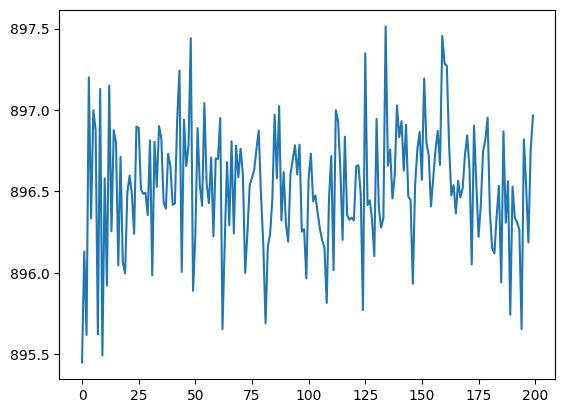

In [29]:
plt.plot(y[:200])

In [15]:
active_low_var_voxels.shape

(90, 128, 85)

In [14]:
L_smooth_val

array([[ 6.93872060e+03, -9.97731913e-01, -9.80884428e-01, ...,
        -2.23385244e-01, -2.22726814e-01, -2.21969498e-01],
       [-9.97731913e-01,  6.94653606e+03, -9.67611500e-01, ...,
        -2.22878587e-01, -2.22322591e-01, -2.21667293e-01],
       [-9.80884428e-01, -9.67611500e-01,  6.77298910e+03, ...,
        -2.22120755e-01, -2.21667293e-01, -2.21114319e-01],
       ...,
       [-2.23385244e-01, -2.22878587e-01, -2.22120755e-01, ...,
         6.96228248e+03, -9.99772959e-01, -9.99092147e-01],
       [-2.22726814e-01, -2.22322591e-01, -2.21667293e-01, ...,
        -9.99772959e-01,  6.94997881e+03, -9.99772959e-01],
       [-2.21969498e-01, -2.21667293e-01, -2.21114319e-01, ...,
        -9.99092147e-01, -9.99772959e-01,  6.93524128e+03]],
      shape=(12558, 12558))

In [40]:
active_low_var_voxels.shape

(90, 128, 85)

In [39]:
np.asarray(w.value).ravel()

array([0.00021066, 0.00021004, 0.00021383, ..., 0.00020997, 0.00021056,
       0.00021097], shape=(12558,))

In [34]:
w.value.max()

np.float64(0.0)

In [10]:
best_score

np.float64(0.0)

In [ ]:
selected_voxels, trial_indices = active_low_var_voxels, None

## L_task Vector (contains beta values for selected voxels)##
num_total_trials = betasmd.shape[-1]
if trial_indices is None:
    trial_indices = np.arange(num_total_trials)

V1 = betasmd[selected_voxels.astype(bool), :][:, trial_indices]
mean_V1 = np.mean(V1, axis=-1)
L_task = np.divide(1., np.abs(mean_V1), out=np.zeros_like(mean_V1), where=mean_V1 != 0)
# L_task = 1./np.abs(mean_V1)


BOLD_data = nib.load(BOLD_path_org).get_fdata() #(90, 128, 85, 850)
selected_BOLD_data = BOLD_data[selected_voxels.astype(bool), :]
selected_BOLD_data_reshape = np.zeros((selected_BOLD_data.shape[0], num_total_trials, trial_len))
start = 0
for i in range(num_trials):
    selected_BOLD_data_reshape[:, i, :] = selected_BOLD_data[:, start:start+trial_len]
    start += trial_len
    if start == 270 or start == 560:
        start += 20
selected_BOLD_data_subset = selected_BOLD_data_reshape[:, trial_indices, :]

## L_var matrix (contains variance of selected voxels)##
diff_mat = np.diff(selected_BOLD_data_subset, axis=1)
diff_mat_flat = diff_mat.reshape(diff_mat.shape[0], -1)
L_var = np.cov(diff_mat_flat, bias=False)
L_var = (L_var + L_var.T) / 2 + 1e-6 * np.eye(L_var.shape[0])
# C2 = diff_mat_flat @ diff_mat_flat.T
# L_var = C2 / selected_BOLD_data_reshape.shape[1]


## L_smooth matrix (contains distance beyween selected voxels)##
anat_img_shape = anat_img.shape
coords = np.array(np.meshgrid(
    np.arange(anat_img_shape[0]),
    np.arange(anat_img_shape[1]),
    np.arange(anat_img_shape[2]),
    indexing='ij'
)).reshape(3, -1).T

# Convert to world (scanner/MNI) coordinates
world_coords = nib.affines.apply_affine(affine, coords)
tmp = selected_voxels.astype(bool).reshape(-1)
selected_world_coords = world_coords[tmp,:]
D = cdist(selected_world_coords, selected_world_coords)
sigma = np.median(D[D>0])
W = np.exp(-D**2 / (2*sigma**2))      # similarity
np.fill_diagonal(W, 0.0)
L_smooth = csgraph.laplacian(W, normed=False)
# L_smooth = csgraph.laplacian(D)

In [ ]:
L_task, L_var, L_smooth, selected_BOLD_data = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, None, trial_len)

In [ ]:
# %% 

weights = optimize_voxel_weights(L_task, L_var, L_smooth, alpha_var=0.1, alpha_smooth=0.1, alpha_sparse=0.01)
weight_img, masked_weights, y = select_opt_weight(selected_BOLD_data, weights, active_low_var_voxels.astype(bool), affine)

np.save("best_params.npy", best_params)
np.save("masked_weights.npy", masked_weights)
np.save("all_weights.npy", weight_img)
np.save("reconstructed_sig.npy",y)


save_path = f"opt_5_percent_weight_on_brain_session{ses}_run{run}.png"
plot_on_brain(anat_img, weight_img, save_path)

finish = 1
